# Softmax

Simple 1D softmax classifier model with cross-entropy loss. Includes support for:

- Training on minibatches of training examples at a time
- Finite difference gradient checking
- L2 Regularization

In [2]:
from collections import namedtuple

Model = namedtuple('Model', ['x', 'y', 'w1', 'b1', 'score1', 'w2', 'b2', 'score2', 'prob1', 'prob2', 'dscore1', 'dscore2', 'db1', 'dw1', 'db2', 'dw2', 'loss'])
State = namedtuple('State', ['loss', 'dws', 'dbs'])

In [3]:
def softmax(scores):
    """Compute the softmax between two numbers
    
    s1 is the number we're finding the softmax of
    
    """
    e_x = np.exp(scores - scores.max())
    
    return e_x / e_x.sum()

In [4]:
class Softmax:
    """Initialize model parameters
    
    Additionally calculate batch index so we can use minibatches with each training iteration
    
    If you want to inspect the scores after each training example, the pass inspect. If you do
    this then you better set a batch_size to 1. Otherwise you'll only ever get the scores of
    the last training example in the minibatch
    
    """
    def __init__(self, xs_train=1, ys_train=1, ws=None, bs=None,
                 learning_rate=0.001, regularizer=1., batch_size=None,
                inspect=False):
        self.m = len(xs_train)
        
        self.xs_train, self.ys_train = xs_train, ys_train
        self.ws, self.bs = np.array([10.,11.]), np.array([100.,101.])
        
        self.learning_rate = learning_rate
        self.regularizer = regularizer
        
        self.batch_size = self.m if not batch_size else batch_size
        self.batch_index = 0
        
        self.inspect = inspect
        
        # Info from the *last* training example that was used to learn from
        self.x, self.y = None, None
        self.scores, self.dscores = None, None
        self.probs = None
        self.dws, self.dbs = None, None
        self.loss = None
        
    def forward_backward_prop(self, ws=None, bs=None):
        """Perform forward and backward prop over a minibatch of training examples
        
        Returns loss and gradients
        
        """
        ws = self.ws if not type(ws) == np.ndarray else ws
        bs = self.bs if not type(bs) == np.ndarray else bs
        
        loss, dws, dbs = 0., np.array([0.,0.]), np.array([0.,0.])
        lower, upper = self.batch_index*self.batch_size, (self.batch_index+1)*self.batch_size
        for x, y in zip(self.xs_train[lower:upper], self.ys_train[lower:upper]):
            # Forward propagation
            scores = np.array([x,x])*ws + bs
            probs = softmax(scores)

            # Accumulate performance loss and regularization loss
            loss += -np.log(probs[y])
            loss += self.regularizer * (0.5*(ws**2).sum() + 0.5*(bs**2).sum())

            # Backpropagate to accumulate dbs and dws
            dloss = 1
            dscores = probs
            dscores[y] -= 1
            dbs += dscores
            dws += x * dscores
            
            # Add regularization factor
            dws += self.regularizer*ws
            dbs += self.regularizer*bs
            
            # Log additional info?
            if self.inspect:
                self.x, self.y = x, y
                self.scores, self.dscores = scores, dscores
                self.dscores[y] += 1
                self.probs = probs
        
        return State(loss/self.m, dws/self.m, dbs/self.m)
    
    def step(self):
        """Run one iteration of gradient descent with a minibatch of training examples"""
        
        loss, dws, dbs = self.forward_backward_prop()
        
        self.ws = self.ws - self.learning_rate*dws
        self.bs = self.bs - self.learning_rate*dbs
        
        # Update batch index so the next time the next batch in line is used
        self.batch_index = (self.batch_index+1) % (self.m//self.batch_size)
        
        # Log additional info?
        if self.inspect:
            self.dws = dws
            self.dbs = dbs
            self.loss = loss

    @property
    def info(self):
        return Model(self.x, self.y,
                     self.ws[0], self.bs[0], self.scores[0], self.ws[1], self.bs[1], self.scores[1],
                     self.probs[0], self.probs[1],
                     self.dscores[0], self.dscores[1],
                     self.dbs[0], self.dws[0],
                     self.dbs[1], self.dws[1],
                     self.loss)

## Run it!

In [28]:
from data.softmax import xs_train, ys_train

sm = Softmax(xs_train, ys_train, learning_rate=0.01, regularizer=.1, batch_size=1, inspect=True)

def states(iters):
    for _ in range(iters):
        sm.step()
        yield sm.info
        
states = list(states(5000))

## Plot the Weights!

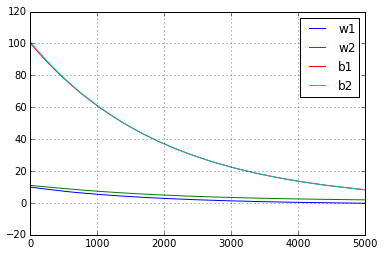

In [29]:
df = pd.DataFrame(states, columns=Model._fields)

axes = df[['w1', 'w2', 'b1', 'b2']].plot()
axes.xaxis.grid(b=True)
axes.yaxis.grid(b=True)

## Plot the Gradients on Each of the Training Examples!

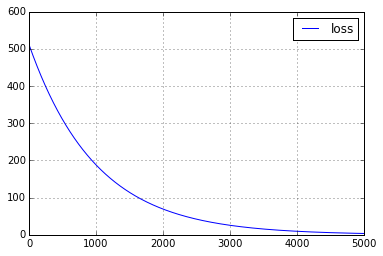

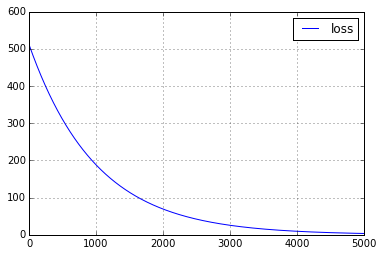

In [30]:
axeses = df.groupby(['x', 'y'])[['loss']].plot()
for axes in axeses:
    axes.xaxis.grid(b=True)
    axes.yaxis.grid(b=True)

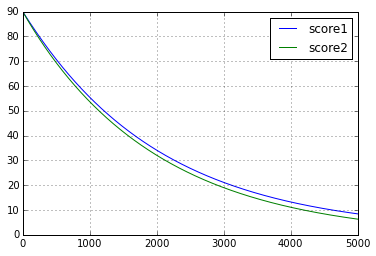

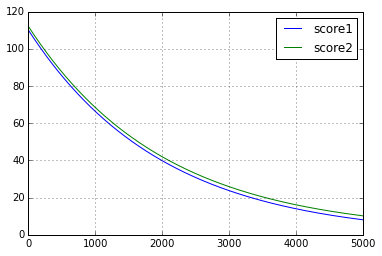

In [31]:
axeses = df.groupby(['x', 'y'])[['score1', 'score2']].plot()
for axes in axeses:
    axes.xaxis.grid(b=True)
    axes.yaxis.grid(b=True)

In [32]:
df[['x', 'y', 'score1', 'score2', 'prob1', 'prob2']]

,x,y,score1,score2,prob1,prob2
0,1,1,110.000000,112.000000,0.119203,0.880797
1,-1,0,89.955000,89.955000,0.500000,0.500000
2,1,1,109.888836,111.889219,0.119163,0.880837
3,-1,0,89.870065,89.860070,0.502499,0.497501
4,1,1,109.777784,111.778549,0.119123,0.880877
5,-1,0,89.785190,89.765260,0.504982,0.495018
6,1,1,109.666843,111.667989,0.119083,0.880917
7,-1,0,89.700375,89.670569,0.507451,0.492549
8,1,1,109.556013,111.557539,0.119043,0.880957
9,-1,0,89.615620,89.575998,0.509904,0.490096


## How Does the Model Evolve Over Time?

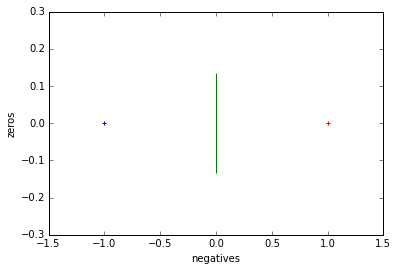

In [33]:
from ipywidgets import interact, fixed

@interact(xs_train=fixed(xs_train), ys_train=fixed(ys_train), view_index=(0, len(states)), states=fixed(states))
def plot(xs_train, ys_train, view_index, states):
    state = states[view_index]
    
    # Get data into suitable form for plotting
    positives, negatives = xs_train[:len(xs_train)//2], xs_train[len(xs_train)//2:]
    df1 = pd.DataFrame({'positives': positives, 'negatives': negatives, 'zeros': np.zeros_like(positives)})
    
    # Solve for the decision boundary
    decision = (state.b2-state.b1) / (state.w1-state.w2)
    
    ys = np.linspace(-.001,.001)
    df2 = pd.DataFrame({'x': [decision], 'y': [0]})
    
    axes = df2.plot(kind='scatter', x='x', y='y', color='g', marker='|', s=10000)
    axes = df1.plot(ax=axes, kind='scatter', x='positives', y='zeros', color='r', marker='+')
    df1.plot(ax=axes, kind='scatter', x='negatives', y='zeros', color='b', marker='+')

## Finite Difference Gradient Check

In [34]:
def numerical_gradients(f, ws, bs):
    """Compute numerical gradients of f with respect to w and b
    
    Returns approximation for df/dw and df/db
    
    """
    dws, dbs = np.zeros_like(ws), np.zeros_like(bs)
    h = np.zeros_like(ws)
    step = 0.00001
    
    # df/dw1 and df/db1
    h[0] = step
    dws[0] = (f(ws+h, bs)  -f(ws-h, bs))   / (2*step)
    dbs[0] = (f(ws,   bs+h)-f(ws,   bs-h)) / (2*step)
    h[0] = 0
    
    # df/dw1 and df/db1
    h[1] = step
    dws[1] = (f(ws+h, bs)  -f(ws-h, bs))   / (2*step)
    dbs[1] = (f(ws,   bs+h)-f(ws,   bs-h)) / (2*step)
    h[1] = 0
    
    return dws, dbs

## Run Through a Few Iterations and Assert Analytic and Numerical Gradients are Close

In [35]:
sm = Softmax(xs_train, ys_train)

for _ in range(10):
    # Analytic gradient computed via backprop
    _, analytic_dws, analytic_dbs = sm.forward_backward_prop()
    
    # Numerical gradient compute via twiddling w and b and inspecting loss
    numerical_dws, numerical_dbs = numerical_gradients(lambda ws, bs: sm.forward_backward_prop(ws, bs).loss, sm.ws, sm.bs)
    
    # Compute relative error
    dws_error = abs(numerical_dws - analytic_dws) / (abs(numerical_dws) + abs(analytic_dws))
    dbs_error = abs(numerical_dbs - analytic_dbs) / (abs(numerical_dbs) + abs(analytic_dbs))
    
    try:
        assert(np.linalg.norm(dws_error) < 1e-6 and np.linalg.norm(dbs_error) < 1e-6)
    except AssertionError:
        warn(dws_error)
        warn(dbs_error)
        
else:
    print('Gradient check passed!')

Gradient check passed!
